In [17]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import glob

%matplotlib inline
plt.rcParams["figure.figsize"] = [24, 18]

In [18]:
#https://github.com/wesm/pydata-book/tree/2nd-edition/datasets/babynames
allFiles = glob.glob("data/*.txt")

list_ = []

for file_ in allFiles:
    df_ = pd.read_csv(file_, index_col=None, header=None,
                      names=['name', 'sex', 'count'])
    df_['year'] = int(file_[-8:-4])
    list_.append(df_)

df = pd.concat(list_)
df.describe()

,count,year
count,1.690784e+06,1.690784e+06
mean,1.906824e+02,1.969454e+03
std,1.615900e+03,3.282353e+01
min,5.000000e+00,1.880000e+03
25%,7.000000e+00,1.946000e+03
50%,1.200000e+01,1.979000e+03
75%,3.200000e+01,1.997000e+03
max,9.965100e+04,2.010000e+03


Общая динамика рождаемости обоих полов

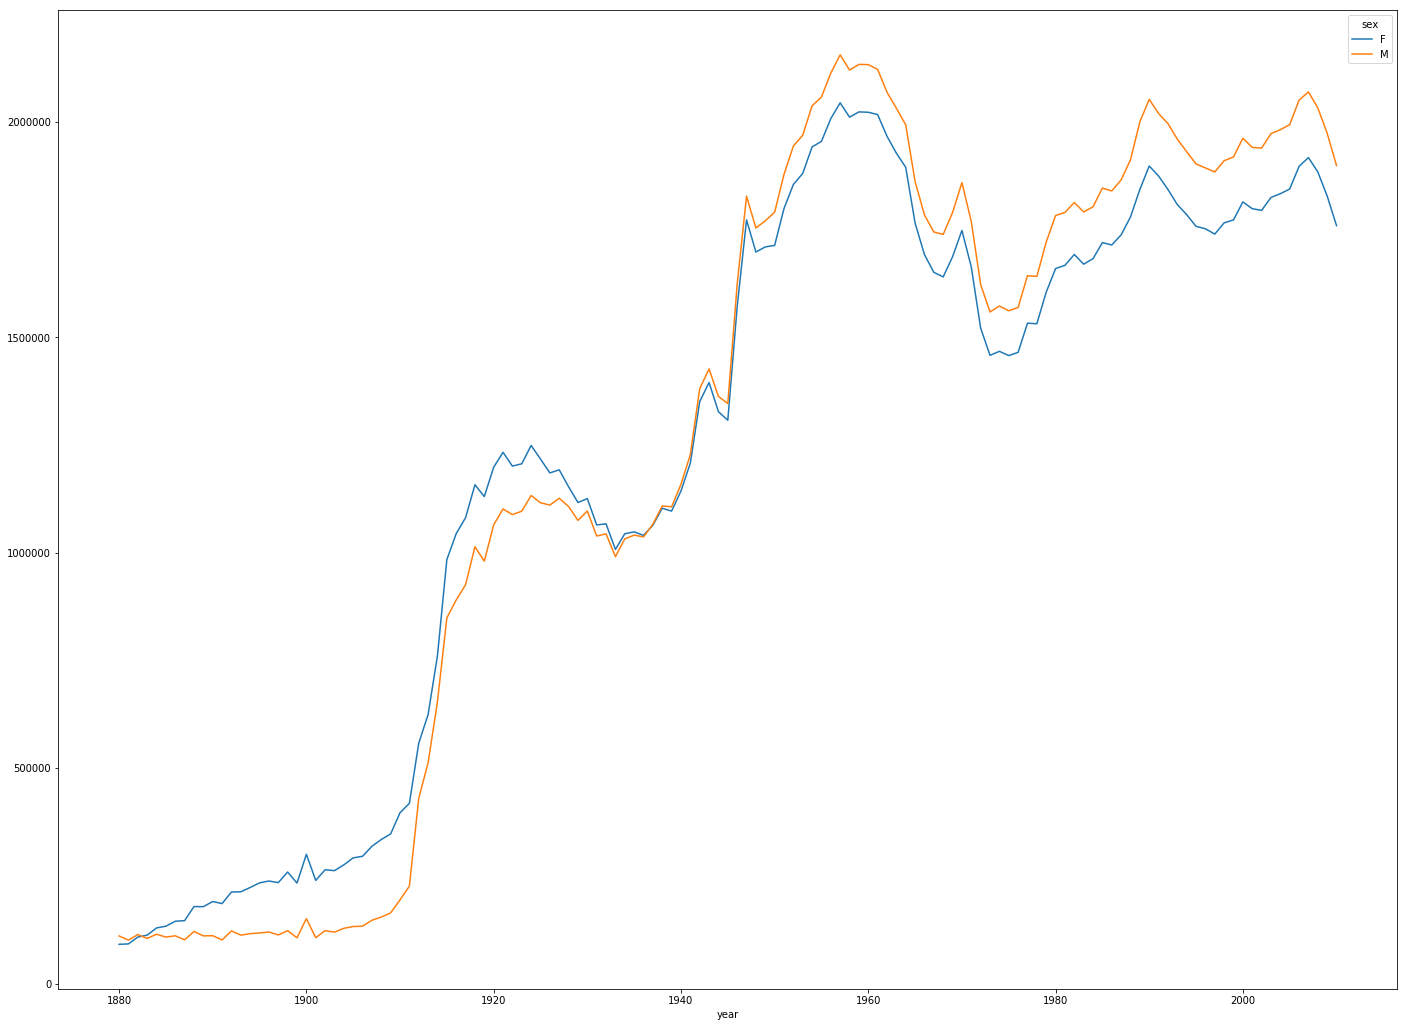

In [19]:
fig, ax = plt.subplots()
df.groupby(['year', 'sex']).sum()['count'].unstack().plot(ax=ax)

Топ 5 популярных имен

In [20]:
lst = []
lst.append(df[df['sex'] == 'M'].groupby(['name', 'sex']).agg(
    {'count': sum}).sort_values('count', ascending=False)[:5])
lst.append(df[df['sex'] == 'F'].groupby(['name', 'sex']).agg(
    {'count': sum}).sort_values('count', ascending=False)[:5])
pd.concat(lst)

,,count
name,sex,
James,M,5049727
John,M,5040319
Robert,M,4767995
Michael,M,4243903
William,M,3986586
Mary,F,4103935
Patricia,F,1568742
Elizabeth,F,1561874
Jennifer,F,1455078


Самые популярные мужское и женское имя

In [21]:
df_m = df[df['sex'] == 'M']
df_f = df[df['sex'] == 'F']
name_m = df_m.groupby(['name']).agg({'count': sum})['count'].idxmax()
name_f = df_f.groupby(['name']).agg({'count': sum})['count'].idxmax()
del df_m, df_f
print(name_m, name_f)

James Mary


Разбейте весь временной промежуток в данных на 10 частей и для каждой найдите самое популярное имя каждого пола. Для каждого найденного имени визуализируйте его динамику за все время

In [22]:
def idmax_name(df):
    return df.idxmax()[2]


df_p = df.groupby([pd.cut(df['year'], np.linspace(
    df['year'].min()-1, df['year'].max(), 10)), 'sex', 'name']).agg({'count': sum})
table = df_p.pivot_table(values='count', index='year',
                         columns='sex', aggfunc=idmax_name)
del df_p
table

sex,F,M
year,,
"(1879.0, 1893.556]",Mary,John
"(1893.556, 1908.111]",Mary,John
"(1908.111, 1922.667]",Mary,John
"(1922.667, 1937.222]",Mary,Robert
"(1937.222, 1951.778]",Mary,James
"(1951.778, 1966.333]",Mary,Michael
"(1966.333, 1980.889]",Jennifer,Michael
"(1980.889, 1995.444]",Jessica,Michael
"(1995.444, 2010.0]",Emily,Jacob


In [23]:
names_f = set(table['F'])
names_m = set(table['M'])
names = set()
names.update(names_f)
names.update(names_m)
names

{'Emily',
 'Jacob',
 'James',
 'Jennifer',
 'Jessica',
 'John',
 'Mary',
 'Michael',
 'Robert'}

In [24]:
df_names = df.pivot_table(values='count', index='year', columns='name',
                          aggfunc=sum).fillna(0)[[name for name in names]]
df_names.head()

name,Jacob,James,Jessica,Michael,John,Jennifer,Mary,Robert,Emily
year,,,,,,,,,
1880,404.0,5949.0,7.0,354.0,9701.0,0.0,7092.0,2427.0,210.0
1881,381.0,5466.0,7.0,298.0,8795.0,0.0,6948.0,2149.0,244.0
1882,390.0,5910.0,8.0,321.0,9597.0,0.0,8179.0,2512.0,272.0
1883,356.0,5249.0,6.0,307.0,8934.0,0.0,8044.0,2345.0,342.0
1884,381.0,5726.0,14.0,373.0,9427.0,0.0,9253.0,2476.0,364.0


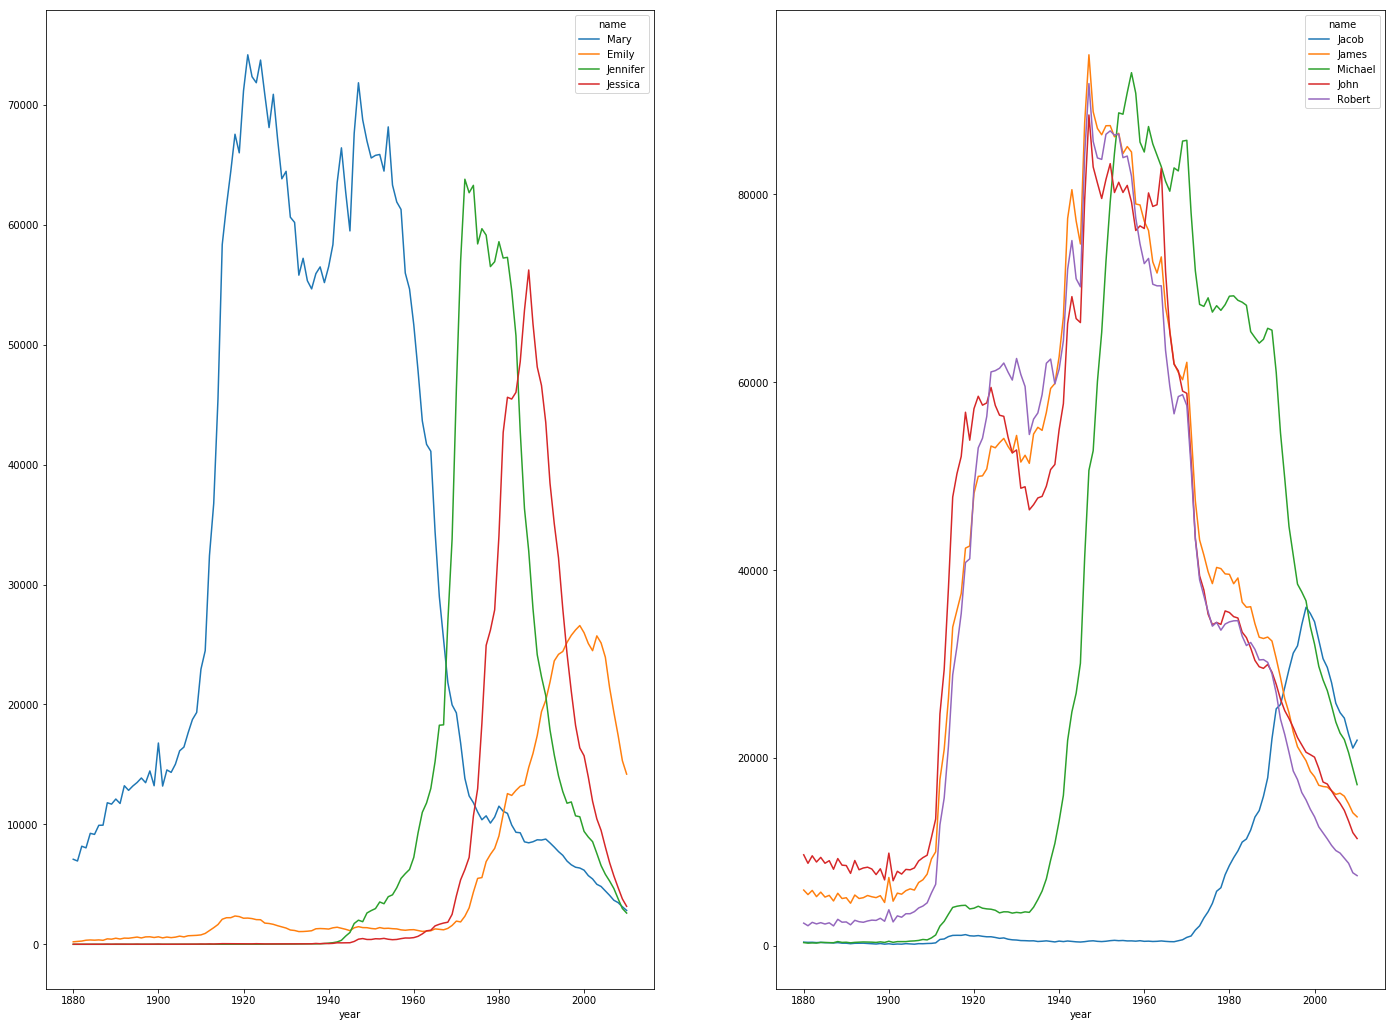

In [25]:
fig, ax = plt.subplots(1, 2)
df_names[[name for name in names_f]].plot(ax=ax[0])
df_names[[name for name in names_m]].plot(ax=ax[1])

Для каждого года рассчитайте сколько имен покрывают 50% людей, визуализируйте (мы увидим разнообразие имен за каждый год)

In [26]:
# def add_perc(group):
#     count_b = group['count'].astype(float)
#     group['perc'] = count_b/np.sum(count_b)
#     return group

# df_per = df.groupby(['year', 'sex'])
# df_per = df_per.apply(add_perc)
# df_per = df_per.sort_values(['year', 'perc'], ascending=[True, False])
# df_per.reset_index(inplace=True)
# rewrite it. couse: too slow

df_a = df.groupby(['year', 'sex', 'name'])['count'].sum().reset_index()
df_b = df.groupby(['year', 'sex']).agg(
    {'count': 'sum'}).add_suffix('_Sum').reset_index()

df_per = pd.merge(df_a, df_b)
df_per['perc'] = df_per['count']/df_per['count_Sum']
df_per.drop(['count_Sum'], inplace=True, axis=1)
del df_a, df_b

df_per = df_per.sort_values(['year', 'perc'], ascending=[
                            True, False]).reset_index()
df_per.drop(['index'], inplace=True, axis=1)

df_per.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690784 entries, 0 to 1690783
Data columns (total 5 columns):
year     1690784 non-null int64
sex      1690784 non-null object
name     1690784 non-null object
count    1690784 non-null int64
perc     1690784 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 64.5+ MB


In [27]:
df_per['cumsum'] = df_per.groupby(['year', 'sex'])['perc'].cumsum()
df_cum = df_per[df_per['cumsum'] <= 0.5].reset_index()
df_cum.drop('index', 1, inplace=True)
del df_per
df_cum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13732 entries, 0 to 13731
Data columns (total 6 columns):
year      13732 non-null int64
sex       13732 non-null object
name      13732 non-null object
count     13732 non-null int64
perc      13732 non-null float64
cumsum    13732 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 643.8+ KB


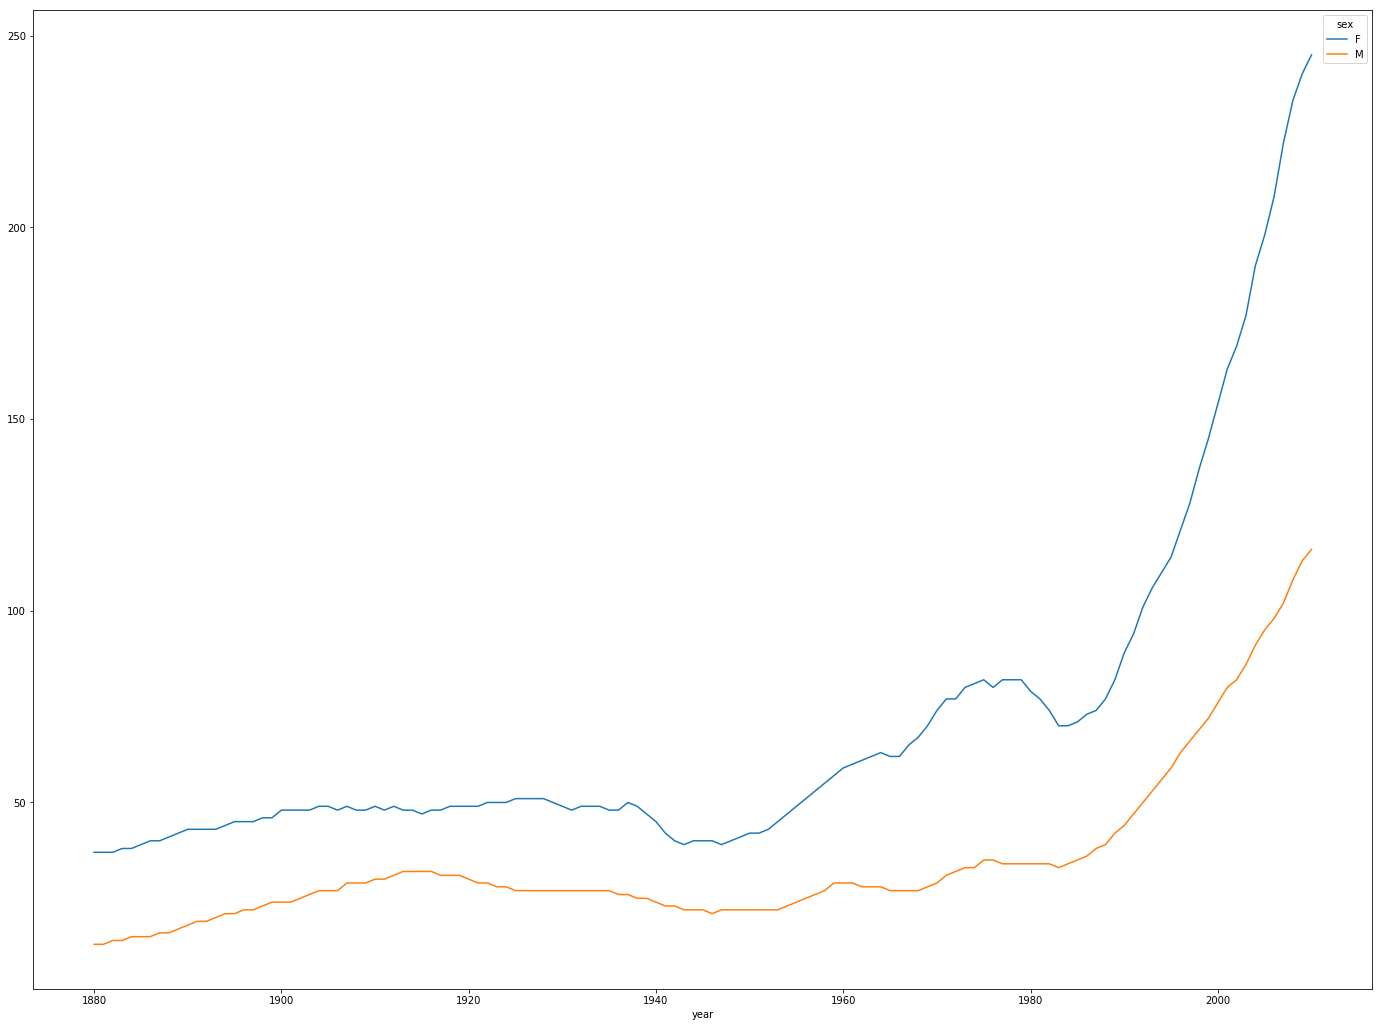

In [28]:
df_cum.groupby(['year', 'sex'])['name'].count().unstack().plot()

Выберите 4 года из всего промежутка и отобразите для каждого года распределение по первой букве в имени, по последней букве в имени

In [29]:
df_year = df[df['year'] > 2006]
df_year['first_str'] = df_year['name'].astype(str).str[0]
df_year['last_str'] = df_year['name'].astype(str).str[-1]

/home/necromant/.virtualenvs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/necromant/.virtualenvs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


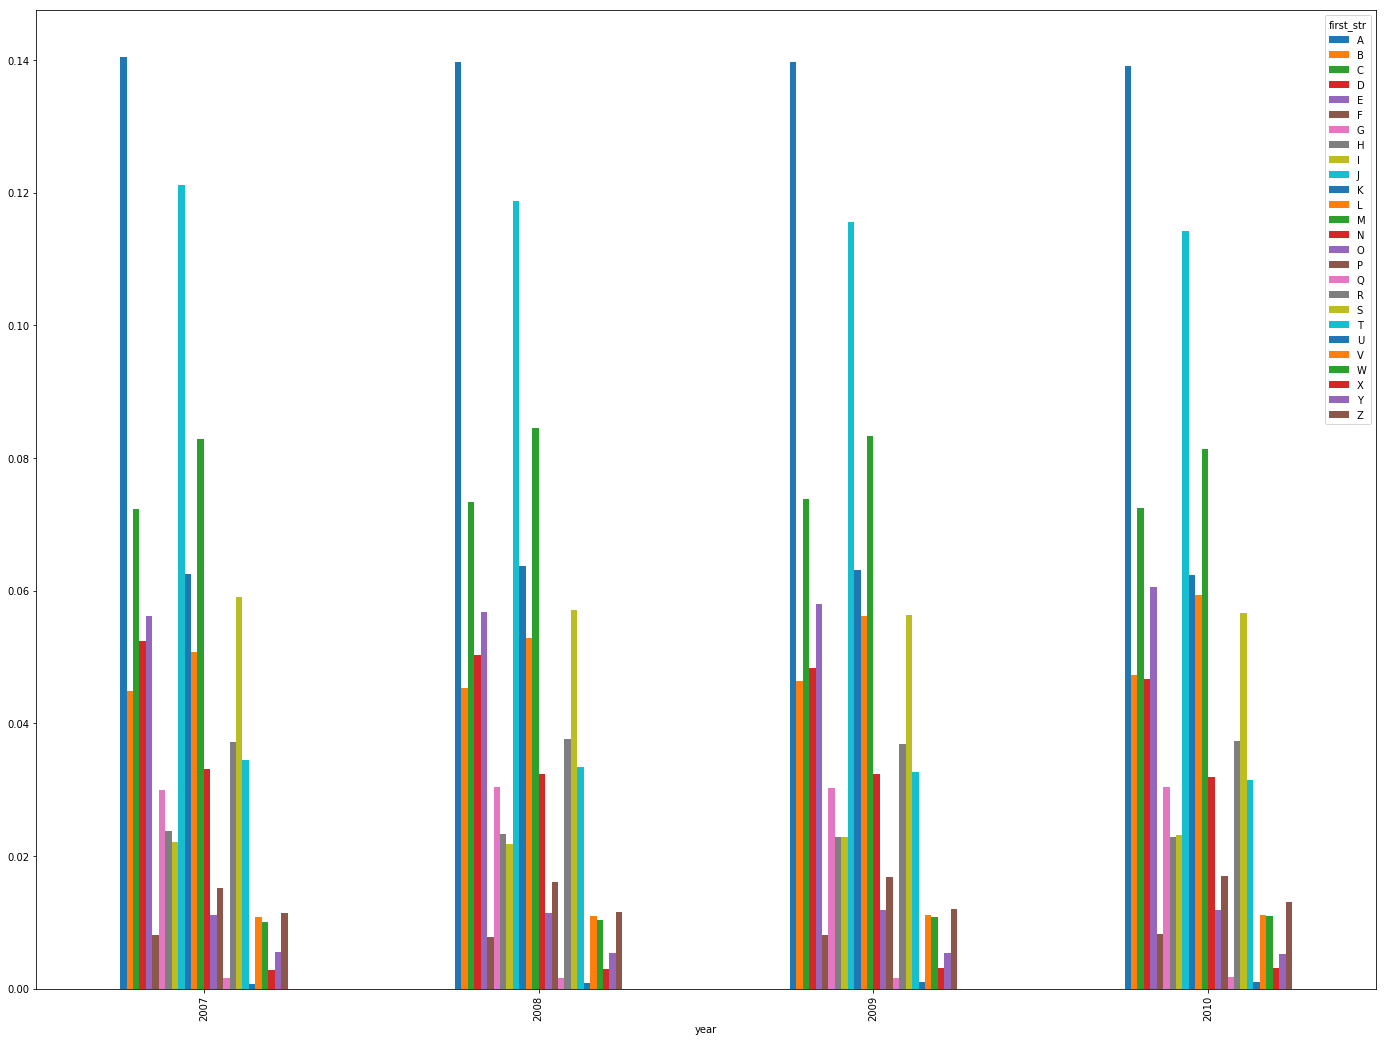

In [30]:
df_first = df_year.groupby(['year', 'first_str'])['count'].sum()

df_first.groupby(['year']).apply(lambda x: x/x.sum()).unstack().plot.bar()

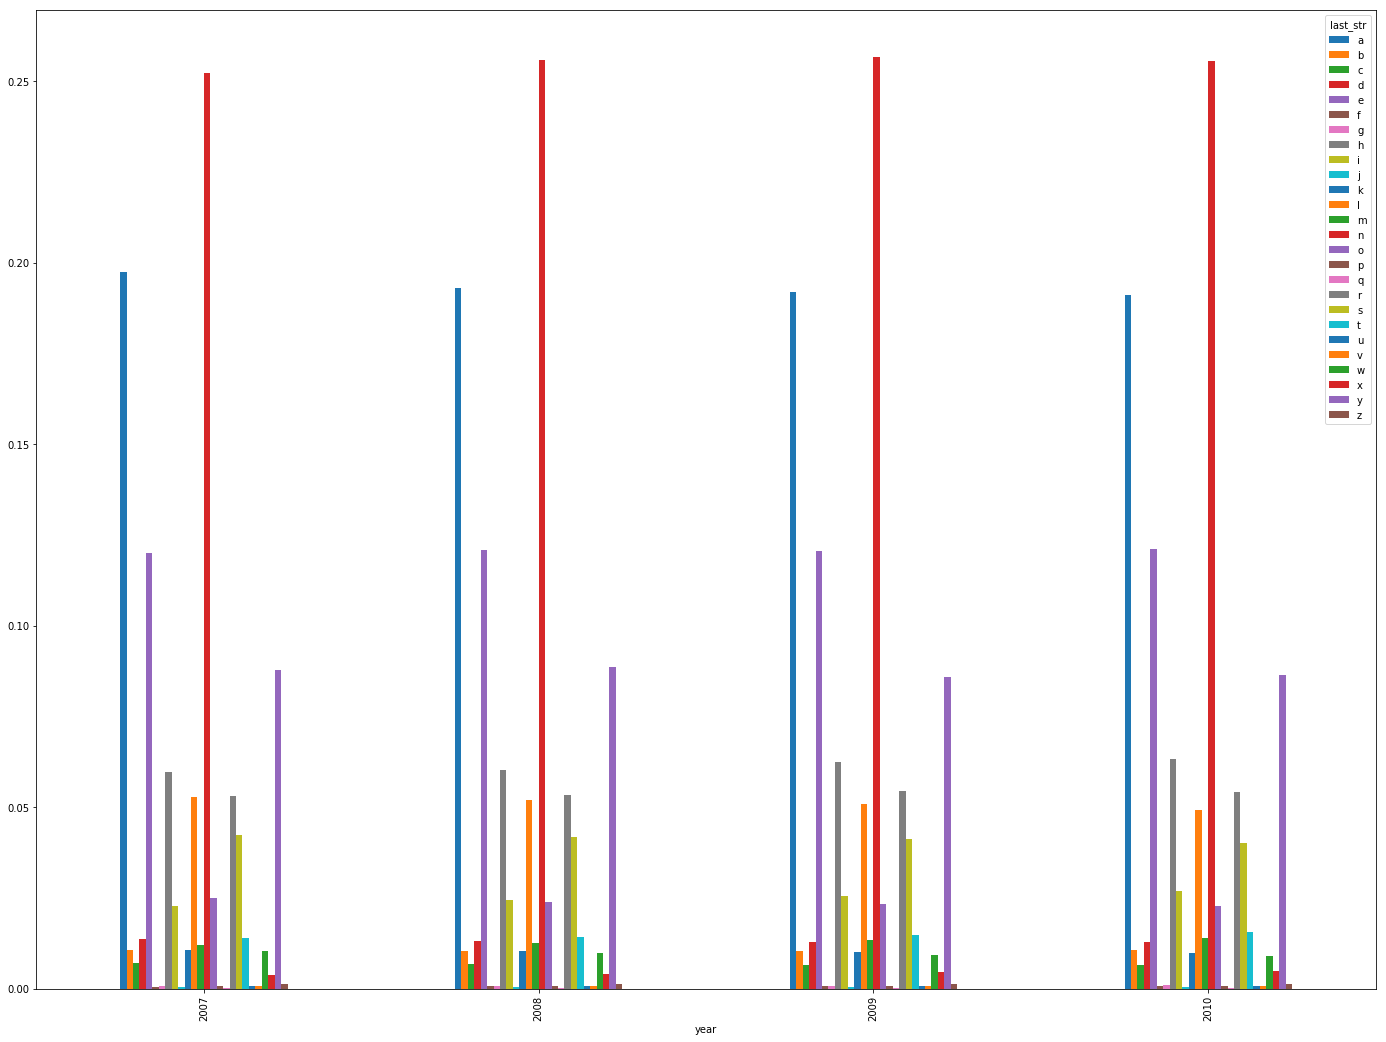

In [31]:
df_last = df_year.groupby(['year', 'last_str'])['count'].sum()

df_last.groupby(['year']).apply(lambda x: x/x.sum()).unstack().plot.bar()

Составьте список из нескольких известных людей (президенты, певцы, актеры, киногерои) и оцените их влияние на динамику имен, постройте наглядную визуализацию

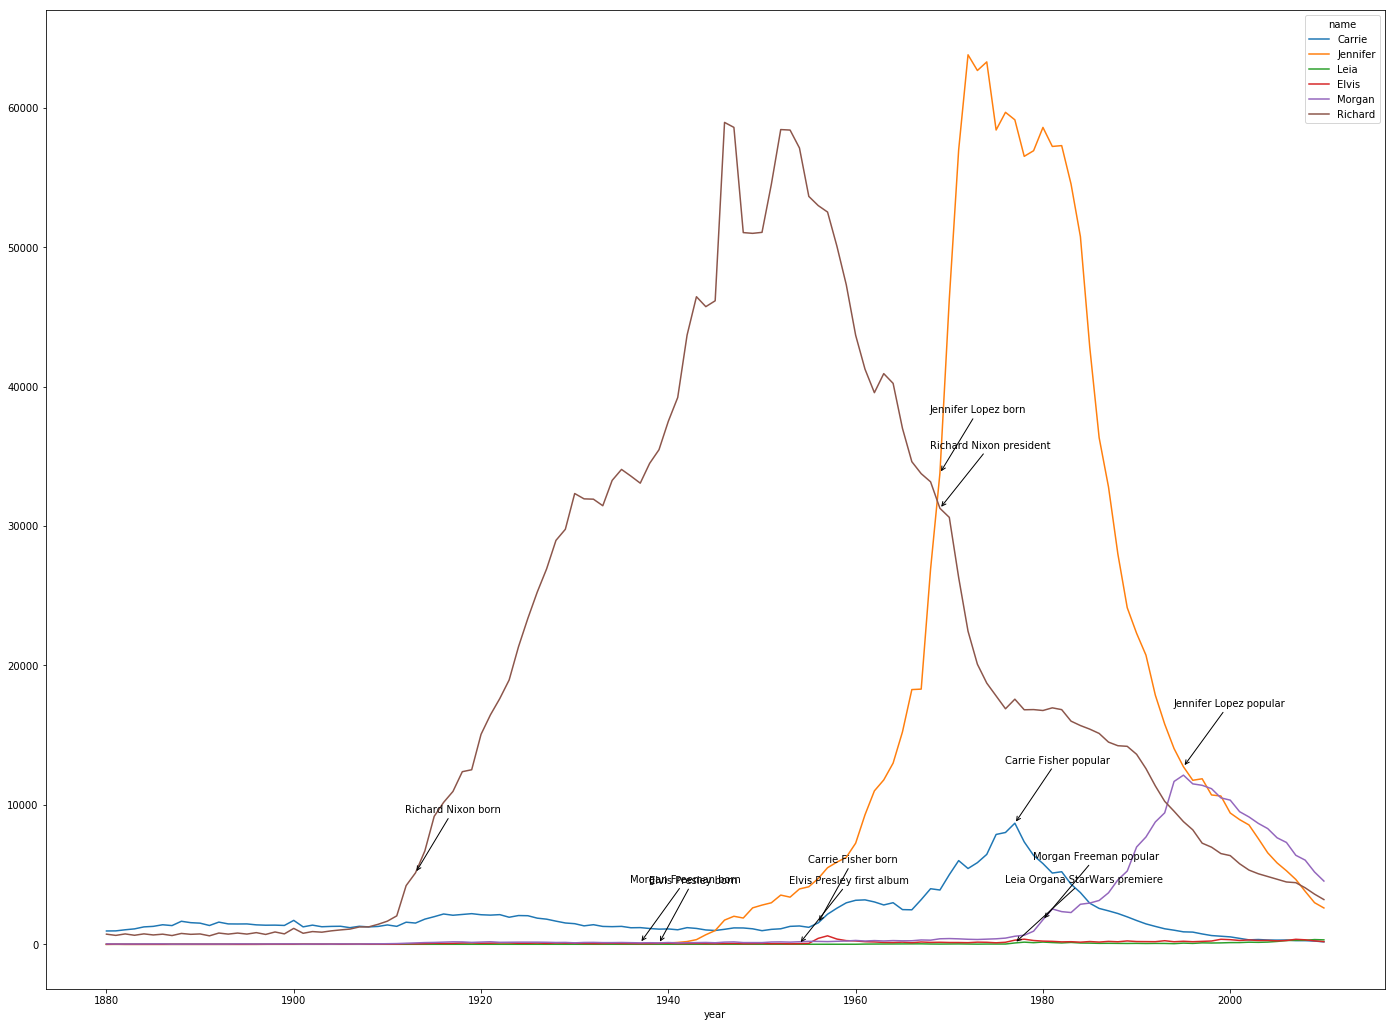

In [32]:
# Richard Nixon born 1913 president 1969-1974
# Jennifer Lopez singer born 1969 popular from 1995
# Elvis Presley singer born 1939 popular from 1954
# Carrie Fisher actress born 1956 StarWars 1977
# Leia Organa from StarWars 1977
# Morgan Freeman actor born 1937 films 1980

populars = {
    'Richard Nixon born': 1913,
    'Richard Nixon president': 1969,
    'Jennifer Lopez born': 1969,
    'Jennifer Lopez popular': 1995,
    'Elvis Presley born': 1939,
    'Elvis Presley first album': 1954,
    'Carrie Fisher born': 1956,
    'Carrie Fisher popular': 1977,
    'Leia Organa StarWars premiere': 1977,
    'Morgan Freeman born': 1937,
    'Morgan Freeman popular': 1980
}

names = set([name.split(' ')[0] for name in populars.keys()])
df_popular = df.pivot_table(values='count', index='year',
                            columns='name', aggfunc=sum).fillna(0)[[name for name in names]]
y_max = df_popular.values.max()
fig, ax = plt.subplots()
df_popular[[name for name in names]].plot(ax=ax)
for e_name, year in populars.items():
    x = year
    y = df_popular[e_name.split(' ')[0]].loc[year]
    ax.annotate(e_name,
                xy=(x, y), xycoords='data',
                xytext=(-10, 60), textcoords='offset points',
                arrowprops=dict(arrowstyle="->"))